In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('"D:\\nowcasting\\IMDDataset\\RF25_ind2020_rfp25.nc"'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **First we need to intall some important libraries to run NetCDF file**

In [2]:
pip install metpy

     -------------------------------------- 409.5/409.5 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 64.6/64.6 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install rioxarray

     -------------------------------------- 61.0/61.0 kB 540.3 kB/s eta 0:00:00
     ---------------------------------------- 24.3/24.3 MB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install earthpy

Note: you may need to restart the kernel to use updated packages.Collecting earthpy
     ---------------------------------------- 1.4/1.4 MB 1.3 MB/s eta 0:00:00




[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%pip install shapely --no-binary shapely

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
# netCDF4 needs to be installed in your environment for this to work
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
from netCDF4 import date2index
from datetime import datetime
from netCDF4 import Dataset

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")


In [10]:
filename = "D:\\nowcasting\\IMDDataset\\RF25_ind2020_rfp25.nc"
data = xr.open_dataset(filename)  

In [11]:
data

<xarray.Dataset>
Dimensions:    (LONGITUDE: 135, LATITUDE: 129, TIME: 366)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 20-Jan-23
    Conventions:  CF-1.6

The data set has been taken from the open source website of the EEA-European Environmental Agency. The data set contains rainfall data from European countries. The data spans 10 years from 1st January 2011 to 31st December 2021 with 0.1 degrees and various Attributes, including timestamp, latitude, longitude, and rainfall. The unit of rainfall is millimeters per day. For each longitude latitude value, we have ‘4018’ time stamps. There are 705 longitude and latitude values. The range of latitude is from 25.049860721021005 to 71.4498588252096 and the range of longitude is from -24.950139509199722 to 45.449860209167724.

In [13]:
# View first 5 latitude values
data["RAINFALL"]["LATITUDE"].values[:5]

array([6.5 , 6.75, 7.  , 7.25, 7.5 ])

In [14]:
print("The min and max latitude values in the data is:", 
      data["RAINFALL"]["LATITUDE"].values.min(), 
      data["RAINFALL"]["LATITUDE"].values.max())
print("The min and max longitude values in the data is:", 
      data["RAINFALL"]["LONGITUDE"].values.min(), 
      data["RAINFALL"]["LONGITUDE"].values.max())

The min and max latitude values in the data is: 6.5 38.5
The min and max longitude values in the data is: 66.5 100.0


In [16]:
# View first 5 and last. 5 time values - notice the span of
# dates range from 2011 to 2021
print("The earliest date in the data is:", data["RAINFALL"]["TIME"].values.min())
print("The latest date in the data is:", data["RAINFALL"]["TIME"].values.max())   

The earliest date in the data is: 2020-01-01T00:00:00.000000000
The latest date in the data is: 2020-12-31T00:00:00.000000000


In [17]:
data["RAINFALL"]["TIME"].values.shape

(366,)

In [25]:
# Select a single x,y combination from the data
key=75
longitude = data["RAINFALL"]["LONGITUDE"].values[key]
latitude = data["RAINFALL"]["LATITUDE"].values[key]

print("Long, Lat values:", longitude, latitude)

Long, Lat values: 85.25 25.25


c:\Users\bhuva\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\bhuva\AppData\Local\Programs\Python\Python310\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


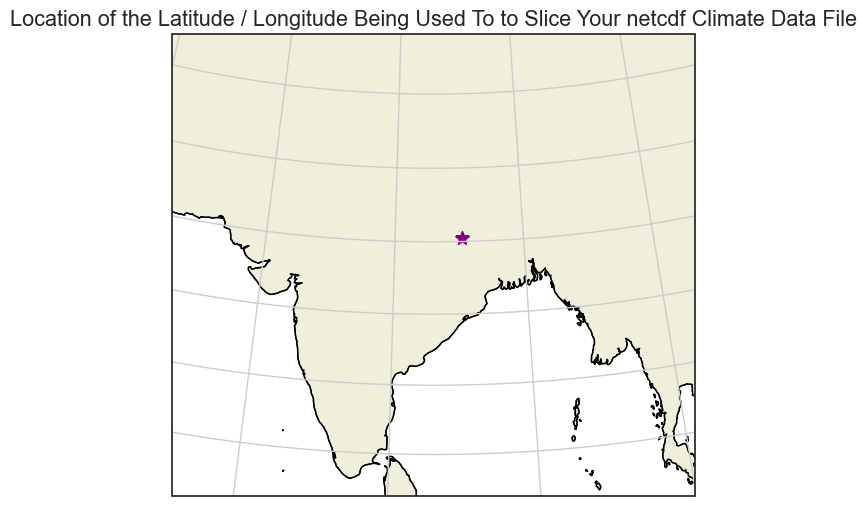

In [26]:
# Create a spatial map of your selected location with cartopy

# Set the spatial extent to cover the CONUS (Continental United States)
extent = [66,100,6,38]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Create your figure and axis object
# Albers equal area is a common CRS used to make maps of the Europe
f, ax = plt.subplots(figsize=(12, 6),
                     subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location
ax.plot(longitude, latitude, 
        '*', 
        transform=ccrs.PlateCarree(),
        color="purple", 
        markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

The data preprocessing stage comprises three exercises: cleaning, standardization, and parting. In our dataset, we haven’t the missing information. I already discuss we have netCDF format which has time series data of all locations in Europe. In preprocessing the first stage in our case was to extract data from some fixed location. For allocating this location we chose the area which probably has the high rainfall in the historical data of the last ten year from 2011 to 2021. By fixing the value of longitude = 10.0498 and for latitude= 60.0498, I extracted the time series data of rainfall with 4018 rows. This place is near Oslo, Norway.  In figure 3, The steric mark is indicating the location of data used in this project.  
The standardization method brings the property estimations inside a specific reach. These cleaning and standardization exercises help the relapse in getting the greatest exactness.	

In [30]:
start_date = "2020-01-01"
end_date = "2020-12-31"

five_years_conus = data["RAINFALL"].sel(
    TIME=slice(start_date, end_date))
# Notice that time has a value of **2** below representing two time steps or months worth of data
five_years_conus 

<xarray.DataArray 'RAINFALL' (TIME: 366, LATITUDE: 129, LONGITUDE: 135)>
[6373890 values with dtype=float64]
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind2020_rfp25.grd

In [31]:
five_years_conus.shape

(366, 129, 135)

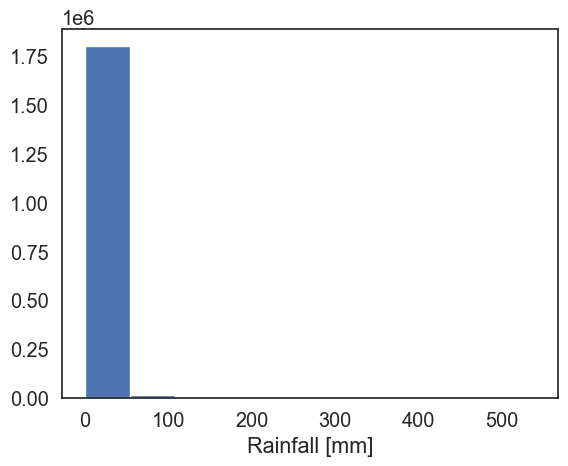

In [32]:
# Directly plot just a single day using time in "years"
five_years_conus.plot()
plt.show()

In [35]:
start_date = "2020-01-01"
end_date = "2020-12-31"
rr_2020 = data["RAINFALL"].sel(
    TIME=slice(start_date, end_date),
    LATITUDE=slice(6.5, 38.5),
    LONGITUDE=slice(66.5, 100.0)
)
rr_2020

<xarray.DataArray 'RAINFALL' (TIME: 366, LATITUDE: 129, LONGITUDE: 135)>
[6373890 values with dtype=float64]
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Attributes:
    long_name:  Rainfall
    units:      mm
    history:    From ind2020_rfp25.grd

In [36]:
# View the 60 data points (raster cell values) associated with the spatial and temporal subset
rr_2020.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [37]:
# Convert to dataframe -- then this can be exported to a csv if you want that
rr_2020_df = rr_2020.to_dataframe()
# View just the first 5 rows of the data
rr_2020_df

RAINFALL
TIME       LATITUDE LONGITUDE          
2020-01-01 6.5      66.50           NaN
                    66.75           NaN
                    67.00           NaN
                    67.25           NaN
                    67.50           NaN
...                                 ...
2020-12-31 38.5     99.00           NaN
                    99.25           NaN
                    99.50           NaN
                    99.75           NaN
                    100.00          NaN

[6373890 rows x 1 columns]

In [38]:
rr_2020_df.describe()

,RAINFALL
count,1.816824e+06
mean,3.487696e+00
std,1.154617e+01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,9.631887e-01
max,5.399128e+02


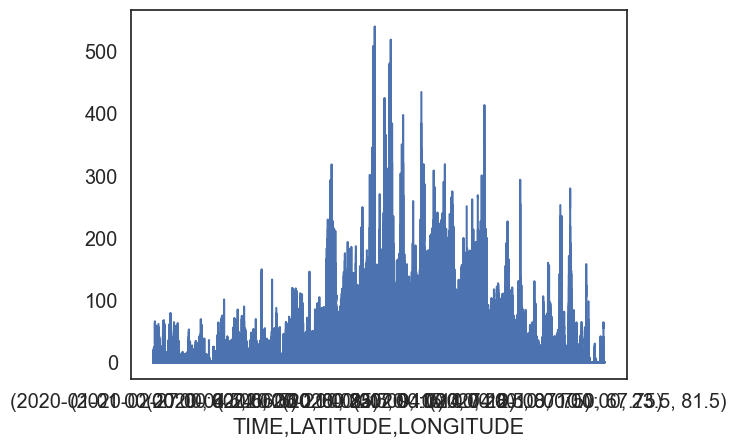

In [39]:
rr_2020_df['RAINFALL'].plot(kind='line')
plt.show()

In [41]:
rr_2020_df['RAINFALL'].shape

(6373890,)

In [42]:
rr_2020_df['rr_one_day'] = rr_2020_df['RAINFALL'].shift(+1)
rr_2020_df['rr_two_day'] = rr_2020_df['RAINFALL'].shift(+2)
rr_2020_df['rr_three_day'] = rr_2020_df['RAINFALL'].shift(+3)
rr_2020_df['rr_four_day'] = rr_2020_df['RAINFALL'].shift(+4)
rr_2020_df['rr_five_day'] = rr_2020_df['RAINFALL'].shift(+5)
rr_2020_df['rr_six_day'] = rr_2020_df['RAINFALL'].shift(+6)
rr_2020_df['rr_seven_day'] = rr_2020_df['RAINFALL'].shift(+7)
rr_2020_df

RAINFALL  rr_one_day  rr_two_day  rr_three_day  \
TIME       LATITUDE LONGITUDE                                                   
2020-01-01 6.5      66.50           NaN         NaN         NaN           NaN   
                    66.75           NaN         NaN         NaN           NaN   
                    67.00           NaN         NaN         NaN           NaN   
                    67.25           NaN         NaN         NaN           NaN   
                    67.50           NaN         NaN         NaN           NaN   
...                                 ...         ...         ...           ...   
2020-12-31 38.5     99.00           NaN         NaN         NaN           NaN   
                    99.25           NaN         NaN         NaN           NaN   
                    99.50           NaN         NaN         NaN           NaN   
                    99.75           NaN         NaN         NaN           NaN   
                    100.00          NaN         NaN         NaN           NaN   

                               rr_four_day  rr_five_day  rr_six_day  \
TIME       LATITUDE LONGITUDE                                         
2020-01-01 6.5      66.50              NaN          NaN         NaN   
                    66.75              NaN          NaN         NaN   
                    67.00              NaN          NaN         NaN   
                    67.25              NaN          NaN         NaN   
                    67.50              NaN          NaN         NaN   
...                                    ...          ...         ...   
2020-12-31 38.5     99.00              NaN          NaN         NaN   
                    99.25              NaN          NaN         NaN   
                    99.50              NaN          NaN         NaN   
                    99.75              NaN          NaN         NaN   
                    100.00             NaN          NaN         NaN   

                               rr_seven_day  
TIME       LATITUDE LONGITUDE                
2020-01-01 6.5      66.50               NaN  
                    66.75               NaN  
                    67.00               NaN  
                    67.25               NaN  
                    67.50               NaN  
...                                     ...  
2020-12-31 38.5     99.00               NaN  
                    99.25               NaN  
                    99.50               NaN  
                    99.75               NaN  
                    100.00              NaN  

[6373890 rows x 8 columns]

In [43]:
rr_2020_df = rr_2020_df.dropna()

In [44]:
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200, max_features=3, random_state=3 )

#Boosted Decision Tree
from sklearn.ensemble import GradientBoostingRegressor
GB_reg = GradientBoostingRegressor(n_estimators=100,max_features=3, random_state=1)

#XGB Regression Model
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.01)

In [46]:
# we select feature variables from are x1,x2,x3 and y is as target variable. here we take 'meantemp' as our target variable
x1 ,x2, x3, x4, x5, x6, x7, y = rr_2020_df['rr_one_day'], rr_2020_df['rr_two_day'],rr_2020_df['rr_three_day'], rr_2020_df['rr_four_day'], rr_2020_df['rr_five_day'], rr_2020_df['rr_six_day'], rr_2020_df['rr_seven_day'], rr_2020_df['RAINFALL']
x1 ,x2, x3, x4, x5, x6, x7, y = np.array(x1), np.array(x2), np.array(x3),np.array(x4), np.array(x5), np.array(x6), np.array(x7),np.array(y)
x1 ,x2, x3, x4, x5, x6, x7, y= x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1),  x4.reshape(-1,1),  x5.reshape(-1,1),  x6.reshape(-1,1),  x7.reshape(-1,1),   y.reshape(-1,1)
final_x = np.concatenate((x1,x2,x3,x4,x5, x6, x7), axis=1)
print(final_x)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
#Split data into test and train, we choose last 90 days as test dataset, the remaining dataset we take as train dataset
x_train, x_test, y_train, y_test = final_x[:-100], final_x[-100:], y[:-100], y[-100:]

In [48]:
#fitting models on train dataset
rf_model.fit(x_train, y_train)
GB_reg = GB_reg.fit(x_train, y_train)
xgb_reg = xgb_reg.fit(x_train, y_train)

C:\Users\bhuva\AppData\Local\Temp\ipykernel_14228\1670470341.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train, y_train)
c:\Users\bhuva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
training_subdata = final_x[3718:3918]
training_taget = y[3718:3918]

In [50]:
training_subdata

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11178241, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.11178241, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## **Random Forest Model**

In [51]:
#predictions of models
pred = rf_model.predict(x_test)

In [52]:
#predictions on train dataset for checking the training performance
train_pred_rf = rf_model.predict(training_subdata)

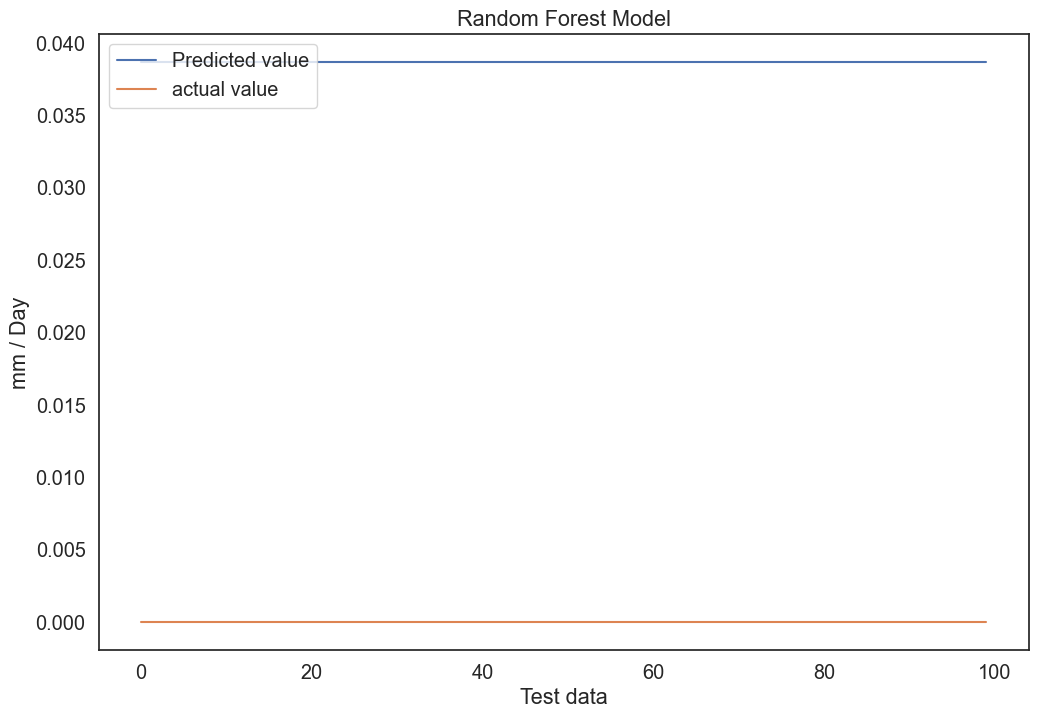

In [53]:
pred = rf_model.predict(x_test)
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(pred, label='Predicted value')
plt.plot(y_test, label='actual value')
plt.legend(loc ="upper left")
plt.title('Random Forest Model')
plt.xlabel('Test data')
plt.ylabel('mm / Day')
plt.show()

## **Gradient Boosted Regression**

In [54]:
#predictions of models
y_pred_GB_reg = GB_reg.predict(x_test)

In [55]:
#predictions on train dataset for checking the training performance
train_pred_GB = GB_reg.predict(training_subdata)

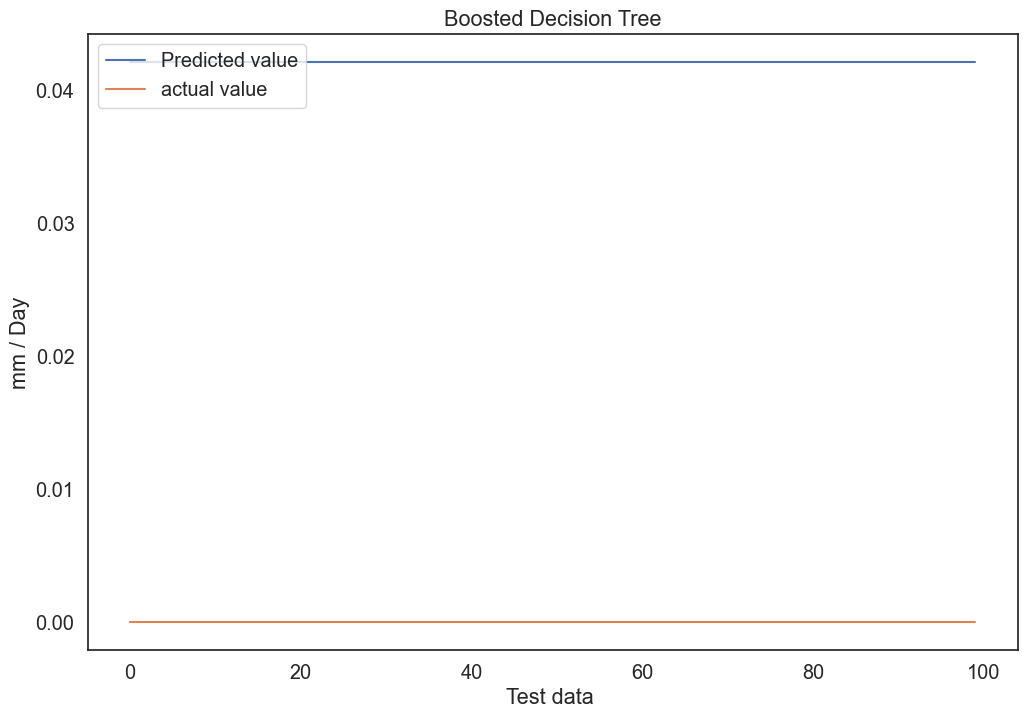

In [56]:
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_pred_GB_reg, label='Predicted value')
plt.plot(y_test, label='actual value')
plt.legend(loc ="upper left")
plt.title('Boosted Decision Tree')
plt.xlabel('Test data ')
plt.ylabel('mm / Day')
plt.show()

# **XGBoost Regression**

In [57]:
#predictions of models
y_pred_XGB_reg= xgb_reg.predict(x_test)

In [58]:
#predictions on train dataset for checking the training performance
train_pred_XGB = xgb_reg.predict(training_subdata)

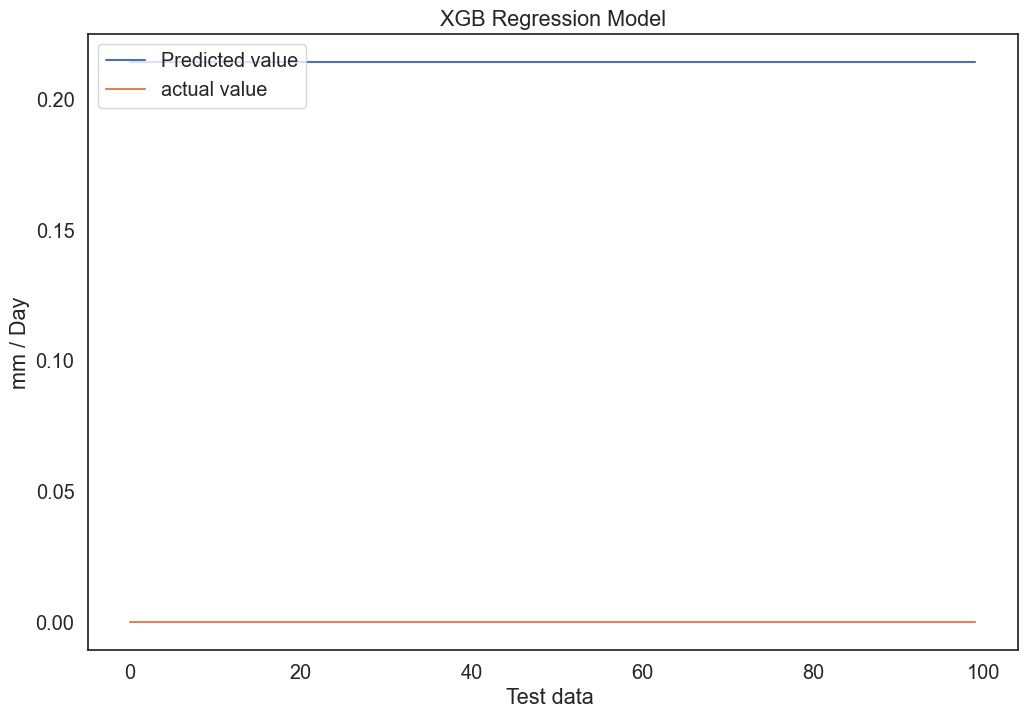

In [59]:
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_pred_XGB_reg, label='Predicted value')
plt.plot(y_test, label='actual value')
plt.legend(loc ="upper left")
plt.title('XGB Regression Model')
plt.xlabel('Test data ')
plt.ylabel('mm / Day')
plt.show()

**Comparing the performance of Models by MSE and RMSE**

In [60]:
from sklearn.metrics import mean_squared_error 
mse_drf = np.round(mean_squared_error(pred, y_test))
mse_gb = np.round(mean_squared_error(y_pred_GB_reg, y_test))
mse_xgb = np.round(mean_squared_error(y_pred_XGB_reg, y_test))
print('Mean squared error of decision random foreset:', mse_drf)
print('Mean squared error of Boosted decision tree regression:', mse_gb)
print('Mean squared error of XGB regression:', mse_gb)

Mean squared error of decision random foreset: 0.0
Mean squared error of Boosted decision tree regression: 0.0
Mean squared error of XGB regression: 0.0


In [61]:
#Predicting the target values of the test set
# RMSE (Root Mean Square Error)
rmse_rf = float(format(np.sqrt(mean_squared_error(y_test, pred)), '.3f'))
rmse_GB = float(format(np.sqrt(mean_squared_error(y_pred_GB_reg, y_test)), '.3f'))
rmse_XGB = float(format(np.sqrt(mean_squared_error(y_pred_XGB_reg, y_test)), '.3f'))
print("\nRMSE of random forest: ", rmse_rf)
print("\nRMSE of Boosted Regression: ", rmse_GB)
print("\nRMSE of XGBoosted Regression: ", rmse_XGB)


RMSE of random forest:  0.039

RMSE of Boosted Regression:  0.042

RMSE of XGBoosted Regression:  0.214


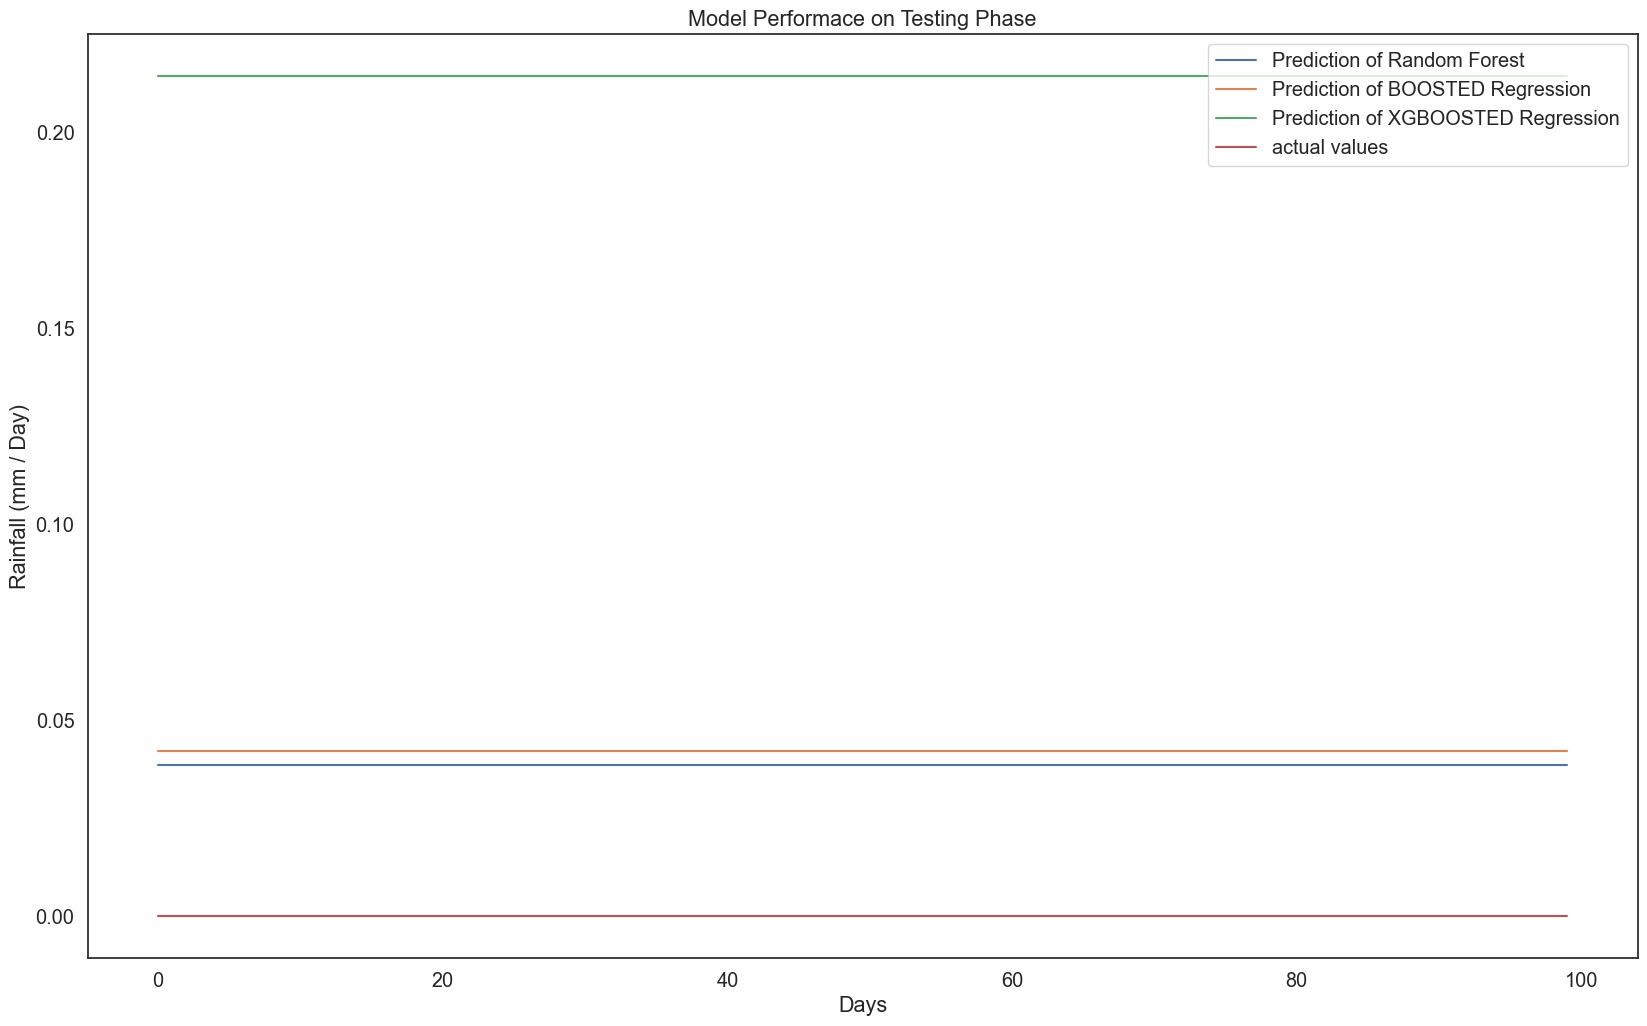

In [63]:
plt.rcParams['figure.figsize'] = (20,12)
plt.plot(pred, label='Prediction of Random Forest')

plt.plot(y_pred_GB_reg, label='Prediction of BOOSTED Regression')
plt.plot(y_pred_XGB_reg, label='Prediction of XGBOOSTED Regression')
plt.plot(y_test, label='actual values')
plt.legend(loc ="upper right")
plt.title('Model Performace on Testing Phase')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm / Day)')
plt.show()

The project focuses on rainfall forecasting using ML models. The main objective was to use different algorithms, for example, Random Forest, Gradient Boosted, XGBoost Regression,  Rainfall forecasting is essentially a time series problem. In this study, we develop this model for time series forecasting. We use univariate time series forecasting because we have only one variable in the data set. 
•	The more data that is remembered for the model, the more exact the model can perform. 
•	The random forest model also improves gradient-boosted regression and XGB-biased regression. 
•	Most of the values in the rainfall dataset are zero after training models on datasets where more than fifty percent of the values are zero, which are difficult to model to learn well. 
